In [1]:
import sys
import os
sys.path.append("..")

In [2]:
from models.vq_vae import VQ_VAE
from utils.e4_temperature_datasets import TemperatureDataset
from utils.e4_temperature_datasets import TemperatureDatasetValid
from utils.e4_temperature_datasets import TemperatureDatasetTest

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torch.autograd import Variable
import torch.nn.functional as F 
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
from matplotlib import pyplot as plt
import datetime

In [4]:
num_hiddens = 32
num_residual_hiddens = 32
num_residual_layers = 2

# embedding_dim = 1 #RJS最初
embedding_dim = 8
num_embeddings = 256

commitment_cost = 0.25

decay = 0.99

In [5]:
batch_size = 32
num_training_updates = 100
num_epochs = 500
learning_rate = 1e-3

# Load Dataset

In [6]:
dataset = TemperatureDataset(transform=transforms.ToTensor())
valid_dataset = TemperatureDatasetValid(transform=transforms.ToTensor())
test_dataset = TemperatureDatasetTest(transform=transforms.ToTensor())

In [7]:
train_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train

In [8]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [ ]:
%%time
model.train()
train_res_recon_error = []
train_res_perplexity = []
recon_error_s = 0
res_perplexity = 0
data_variance = 1
good_id = 0


optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

f_name = "temperature_vq_vae-{}-{}dim".format(num_embeddings, embedding_dim)
dt_now = datetime.datetime.now()
now = "{}-{}-{}".format(dt_now.year, dt_now.month, dt_now.day)
name_dir = "pth/{}".format(now)
name = "pth/{}/{}.pth".format(now, f_name)
if not os.path.isdir(name_dir):
    os.makedirs(name_dir)
log_dir = "logs/{}/{}".format(now, f_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir=log_dir)


for epoch in range(num_epochs):
    model.train()
    recon_error_s = 0
    res_perplexity = 0
    for data in train_loader:
        data = data.to(device, dtype=torch.float)
        data = data.view(data.size(0), 1, -1)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance        
        loss = recon_error + vq_loss
        
        loss.backward()
        optimizer.step()
        
        recon_error_s += recon_error.item()
        res_perplexity += perplexity.item()
        
#         recon_error_s += recon_error.item()
#         res_perplexity += perplexity.item()
        
#         # マルチGPU用
#         loss = loss.mean()
#         #loss.mean().backward()
#         loss.backward()
#         optimizer.step()
#         perplexity = perplexity.mean()
#         recon_error_s += recon_error.item()
#         res_perplexity += perplexity.item()
    writer.add_scalar("train-loss", recon_error_s/len(train_loader), epoch)
    writer.add_scalar("train-perplexity", res_perplexity/len(train_loader), epoch)
    
    recon_error_s = 0
    res_perplexity = 0
    #検証データで評価
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            data = data.to(device, dtype=torch.float)
            data = data.view(data.size(0), 1, -1)
            vq_loss, data_recon, perplexity = model(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            recon_error_s += recon_error.item()
            res_perplexity += perplexity.item()

    train_res_recon_error.append(recon_error_s/len(valid_loader))
    train_res_perplexity.append(res_perplexity/len(valid_loader))
    writer.add_scalar("valid-loss", recon_error_s/len(valid_loader), epoch)
    writer.add_scalar("valid-perplexity", res_perplexity/len(valid_loader), epoch)
    if recon_error_s/len(train_loader) <= train_res_recon_error[good_id]:
        torch.save(model.state_dict(), name)
        good_id = epoch

    
writer.close()

# 復元&食べ物データ確認

In [8]:
num_embeddings = 256
embedding_dim = 8
data_pth = 'pth/2021-9-9/temperature_vq_vae-{}-{}dim.pth'.format(num_embeddings, embedding_dim)

torch.Size([32, 1, 120])


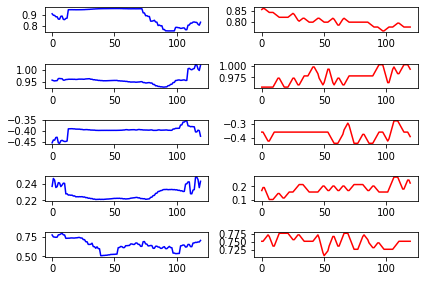

In [9]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load(data_pth))
model.eval()

with torch.no_grad():
    for data in valid_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        print(data.shape)
        vq_loss, data_recon, perplexity = model(data)
#         loss = criterion(net.reconstruction(outputs), data)
#         valid_loss += loss.item()
        break
    
axs = []
fig = plt.figure()
for i in range(10):
    ax = fig.add_subplot(5, 2, i+1)
    axs.append(ax)
reco = data_recon
reco = reco.reshape(-1, data.size(2))
t = [i for i in range(data.size(2))]
#t = [i for i in range(15000)]
for i in range(5):
    y1 = reco[i].to('cpu').detach().numpy().copy()
    y2 = data[i].to('cpu').detach().numpy().copy()
    y2 = y2.reshape(y2.size)

    axs[i*2].plot(t, y1, color='blue', label='reconstruction')
    axs[i*2+1].plot(t, y2, color='red', label='original')
#     axs[i*2].plot(t, y1, color='blue', label='reconstruction')
#     axs[i*2+1].plot(t, y2, color='red', label='original')
fig.tight_layout()
#plt.savefig('1500.png')
plt.show()

## 食べ物のデータ処理

In [10]:
model = VQ_VAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)
model.load_state_dict(torch.load(data_pth))
batch_size = 64
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
criterion = nn.MSELoss()

valid_loss = 0

with torch.no_grad():
    for data in test_loader:
        data = data.view(data.size(0), 1, -1)
        data = data.float()
        data = data.to(device)
        z = model._encoder(data)
        print(z.shape)
        z = model._pre_vq_conv(z)
        print(z.shape)
        loss, quantized, perplexity, _ = model._vq_vae(z)
        break

out = quantized.to('cpu').detach().numpy().copy()
out.shape

torch.Size([32, 32, 59])
torch.Size([32, 4, 59])


(32, 4, 59)

## token_idを取り出す

In [11]:
def get_token_id_from_vqvae(model, data):
        bsz = data.shape[0]
        z = model._pre_vq_conv( model._encoder(data) ) 
        loss, quantized, perplexity, vq_vae_encodings = model._vq_vae(z)
        #token_ids = vq_vae_encodings.argmax(1).view(bsz,-1)
        token_ids = vq_vae_encodings.argmax(2).view(bsz,-1)
        return token_ids

In [12]:
id = get_token_id_from_vqvae(model, data)
id = id.to('cpu').detach().numpy().copy()

In [24]:
ls_all = []
for i in range(len(id)):
    ls = []
    for j in range(num_embeddings):
        count = 0
        for k in range(len(id[0])):
            if(id[i][k] == j):
                count += 1
        ls.append(count)
    ls_all.append(ls)

In [15]:
np.save("temperature_VAE_npy/temperature_vq_vae-{}-{}dim".format(num_embeddings, embedding_dim), ls_all)

(32, 59)

## 使用されているコーパス数を調べる

In [26]:
use_flag = [False] * num_embeddings
for i in range(len(id)):
    for j in range(len(id[i])):
        use_flag[id[i][j]] = True

use_flag.count(True)

88

## コサイン類似度

In [27]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [28]:
id = get_token_id_from_vqvae(model, data)
id = id.to('cpu').detach().numpy().copy()
corpus = model._vq_vae._embedding.weight
corpus = corpus.to('cpu').detach().numpy().copy()

### 得られたベクトルのコーパスを見て隣接するIDとの類似度を見る

In [31]:
cos_sequence = []
all_cos_sequence = []
for i in range(len(id)):
    cos_sequence = []
    for j in range(len(id[i])-1):
        sim = cos_sim(corpus[id[i][j]], corpus[id[i][j+1]])
        cos_sequence.append(sim)
    all_cos_sequence.append(cos_sequence)


food = ['pineapple', 'potato', 'ume', 'chocolate']
for i in range(len(food)):
    sns.heatmap(all_cos_sequence[i*5:(i+1)*5], cmap= sns.color_palette('coolwarm', 10), vmin = -1, vmax = 1)
#     plt.savefig("./fig/test_emg_{}_day1".format(food[i]))
    plt.clf()
    
for i in range(len(food)):
    sns.heatmap(all_cos_sequence[20+i*3:20+(i+1)*3], cmap= sns.color_palette('coolwarm', 10), vmin = -1, vmax = 1)
#     plt.savefig("./fig/test_emg_{}_day1".format(food[i]))
    plt.clf()

<Figure size 432x288 with 0 Axes>

### 食べ物のベクトルの類似度を見る

In [39]:
pine1 = ['pineapple 1d{}t'.format(i) for i in range(5)]
pine2 = ['pineapple 2d{}t'.format(i) for i in range(3)]
potato1 = ['potato 1d{}t'.format(i) for i in range(5)]
potato2= ['potato 2d{}t'.format(i) for i in range(3)]
ume1=['pickled plums 1d{}t'.format(i) for i in range(5)]
ume2=['pickled plums 2d{}t'.format(i) for i in range(3)]
chocolate1 = ['chocolate 1d{}t'.format(i) for i in range(5)]
chocolate2 = ['chocolate 1d{}t'.format(i) for i in range(3)]

index = []
index.extend(pine1)
index.extend(potato1)
index.extend(ume1)
index.extend(chocolate1)
index.extend(pine2)
index.extend(potato2)
index.extend(ume2)
index.extend(chocolate2)

columns = index

all_cos_sequence = []
for i in range(len(index)):
    cos_sequence = []
    for j in range(len(index)):
        cos_sequence.append(cos_sim(id[i], id[j]))
    all_cos_sequence.append(cos_sequence)
all_cos_sequence = np.array(all_cos_sequence)
df = pd.DataFrame(data=all_cos_sequence, index=index, columns=columns, dtype='float')
# print(df)
# df.to_excel('temperature_cos_sim.xlsx')

                    pineapple 1d0t  pineapple 1d1t  pineapple 1d2t  \
pineapple 1d0t            1.000000        0.767259        0.588466   
pineapple 1d1t            0.767259        1.000000        0.684601   
pineapple 1d2t            0.588466        0.684601        1.000000   
pineapple 1d3t            0.678127        0.656603        0.594965   
pineapple 1d4t            0.643512        0.699488        0.575696   
potato 1d0t               0.737633        0.727328        0.673207   
potato 1d1t               0.706116        0.750079        0.617379   
potato 1d2t               0.767543        0.718799        0.710650   
potato 1d3t               0.772277        0.790052        0.750574   
potato 1d4t               0.834509        0.738108        0.736979   
pickled plums 1d0t        0.722131        0.733611        0.624612   
pickled plums 1d1t        0.829165        0.796367        0.740758   
pickled plums 1d2t        0.822925        0.788477        0.687474   
pickled plums 1d3t  

[]

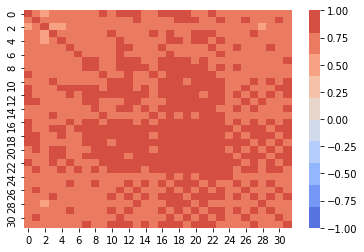

In [40]:
sns.heatmap(all_cos_sequence, cmap= sns.color_palette('coolwarm', 10), vmin = -1, vmax = 1)
plt.plot()

# Decoderへの入力のUMAP解析

In [ ]:
!conda install -y -c conda-forge umap-learn

In [ ]:
import sklearn
from sklearn import preprocessing
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import umap

In [ ]:
def render(ax1, feature, name=None):
    #day1
    ax.scatter(feature[:5,0],feature[:5,1], c='red', marker='x', label='pineapple day1', s=100)
    ax.scatter(feature[5:10,0],feature[5:10,1], c='red',marker='o', label='potato chips day1', s=100)
    ax.scatter(feature[10:15,0],feature[10:15,1],  c='blue',marker='^', label='salted plum day1', s=100)
    ax.scatter(feature[15:20,0],feature[15:20,1], c='blue',marker='s', label='chocolate day1', s=100)

    # day2
    ax.scatter(feature[20:23,0],feature[20:23,1], c='darkred', marker='x', label='pineapple day2', s=100)
    ax.scatter(feature[23:26,0],feature[23:26,1], c='darkred',marker='o', label='potato chips day2', s=100)
    ax.scatter(feature[26:29,0],feature[26:29,1],  c='darkblue',marker='^', label='salted plum day2', s=100)
    ax.scatter(feature[29:,0],feature[29:,1], c='darkblue',marker='s', label='chocolate day2', s=100)
    
#     ax.legend(loc='upper right')
    ax.grid(True)
    if name != None:
        fig.savefig(name, bbox_inch='tight')
    fig.show()

In [ ]:
out = out.reshape(len(out), -1)

#中間層の標準化
ss = preprocessing.StandardScaler()
print(out.shape)
encode = ss.fit_transform(out)

#umap
umap_model = umap.UMAP(n_components=2, random_state=0)
feature = umap_model.fit_transform(encode)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# render(ax, feature)
render(ax, feature)